# Lab 3.

In [1]:
from math import erf, sqrt
from scipy import stats, special
import matplotlib.pyplot as plt
from iism_lab3 import *
from iism_lab2 import a5_generator
%matplotlib inline

In [2]:
def get_a5_generator():
    S19 = np.random.randint(2, size=19)
    S22 = np.random.randint(2, size=22)
    S23 = np.random.randint(2, size=23)
    gen = a5_generator(S19, S22, S23)
    return gen


def uniform_psi(gen, n=10):
    while True:
        yield (int(''.join([str(next(gen)) 
                            for _ in range(n)]), 2) + 1) / (2 ** n + 1)

In [3]:
def poisson_psi(l=1, x=200):
    psi = uniform_psi(get_a5_generator(), n=16)
    p = l / x
    while True:
        k = 0
        for _ in range(x):
            if next(psi) < p:
                k += 1
        yield k


def normal_psi(n, E=0, D=1):
    psi = uniform_psi(get_a5_generator(), n=16)
    while True:
        if n > 0:
            yield E + D * (sum([next(psi) for _ in range(n)]) - n / 2) * (12 / n) ** 0.5
        else:
            yield E + D * (-2 * np.log(next(psi))) ** 0.5 * np.sin(2 * np.pi * next(psi))


def exponential_psi(l=2):
    psi = uniform_psi(get_a5_generator(), n=16)
    while True:
        yield -np.log(next(psi)) / l


def polynomial_psi(n, ps):
    psi = uniform_psi(get_a5_generator(), n=16)
    ps = np.cumsum(ps)
    while True:
        res = []
        for i in range(n):
            val = next(psi)
            for i, p in enumerate(ps):
                if val < p:
                    res.append(i)
                    break
        yield np.histogram(res, bins=len(ps))[0]


def M(res):
    return np.mean(res)


def D(res):
    return np.std(res)

In [4]:
def empirical_histogram(res, left_border, right_border, k):
    step = (right_border - left_border) / k
    ys = np.array([len([t for t in res if xi <= t < xi + step])
                   for xi in np.arange(left_border, right_border, step)]) / len(res)
    return ys


def empirical_distribution_func(res, left_border, right_border, k):
    return np.cumsum(empirical_histogram(res, left_border, right_border, k))


def calc_function(func, xi, params=None):
    return func(xi, **params) if params is not None else func(xi)

In [5]:
def draw_empirical_distribution_func(res, left_border, right_border, k,
                                     func=None, params=None, type='bar', ax=None, label=None, loc=None):
    xs, ys = list(np.arange(left_border, right_border, (right_border - left_border) / (k + 1))), \
             empirical_distribution_func(res, left_border, right_border, k)
    if type == 'bar':
        ax.bar(xs[1:], ys, label=label, color='green')
    elif type == 'plot':
        ax.plot(xs[1:], ys, label=label, color='green')
    ys = [calc_function(func, xi, params) for xi in xs]
    ax.plot(xs, ys, color='blue')
    ax.legend(loc=loc)


def draw_empirical_histogram(res, left_border, right_border, k,
                             func=None, params=None, ax=None, type='bar', label=None, loc=None):
    xs, ys = list(np.arange(left_border, right_border, (right_border - left_border) / (k + 1))), \
             empirical_histogram(res, left_border, right_border, k)
    if type == 'bar':
        ax.bar(xs[1:], ys, label=label, color='green')
    elif type == 'plot':
        ax.plot(xs[1:], ys, label=label, color='green')
    ys = [calc_function(func, xi, params) for xi in xs]
    ax.plot(xs, ys, color='blue')
    ax.legend(loc=loc)

In [6]:
def pearson_test(res, left_border, right_border, k, func, params):
    ys = np.array(empirical_histogram(res, left_border, right_border, k))
    fs = np.array([calc_function(func, xi, params) for xi in np.arange(left_border, right_border, (right_border - left_border) / (k + 1))])
    ps = np.array([fs[i + 1] - fs[i] for i in range(len(fs) - 1)])
    n = sum(ps)
    ps /= n
    xsi = n * np.sum([(y - p) ** 2 / y if y != 0 else 1 for y, p in zip(ys, ps)])
    return special.gammaincc((len(ps) - 1) / 2, xsi / 2)


def kolmogorov_test(res, left_border, right_border, k, func, params):
    ys = empirical_distribution_func(res, left_border, right_border, k)
    dn = np.amax(np.abs(np.array([calc_function(func, xi, params) for xi in np.arange(left_border, right_border, (right_border - left_border) / k)])
                 - np.array(ys)))
    K = len(res) ** 0.5 * dn + 1 / (6 * len(res) ** 0.5)
    P = np.sum((-1) ** j * np.exp(-2 * K * j ** 2) 
               for j in range(-10000, 10001))
    return P

In [7]:
def poisson_distribution_function(x, l):
    return np.sum([l ** k / np.math.factorial(int(k)) * np.exp(-l) if x > 0 else 0
                   for k in range(int(x))])


def poisson_probability_density_function(x, l):
    return l ** x / np.math.factorial(int(x)) * np.exp(-l) if x > 0 else 0


def normal_distribution_function(x, M, D):
    return (1. + erf((x - M) / sqrt(2. * D))) / 2.


def normal_probability_density_function(x, M, D):
    return 1 / sqrt(2 * D * np.pi) * np.exp(- (x - M) ** 2 / (2 * D))


def exponential_distribution_function(x, l):
    return 1 - np.exp(-l * x) if x > 0 else 0


def exponential_probability_density_function(x, l):
    return l * np.exp(-l * x) if x > 0 else 0

In [8]:
psi1 = poisson_psi()
res1 = np.array([next(psi1) for _ in range(2000)])

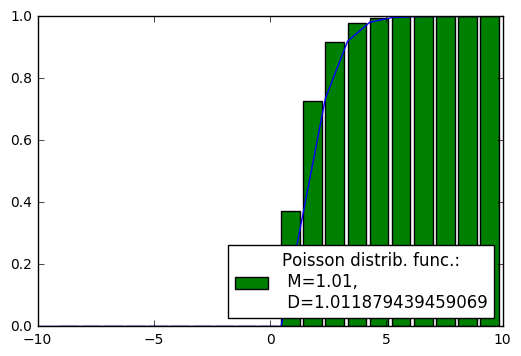

In [9]:
draw_empirical_distribution_func(res1, -10, 10, 20,
                                 func=poisson_distribution_function, ax=plt.gca(), params={'l': 1},
                                 label='Poisson distrib. func.:\n M={},\n D={}'.format(M(res1), D(res1)), loc=4)

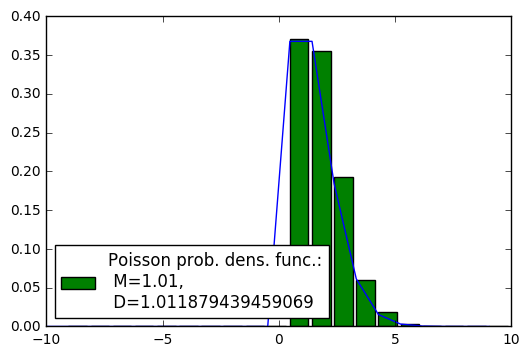

In [10]:
draw_empirical_histogram(res1, -10, 10, 20,
                         func=poisson_probability_density_function, ax=plt.gca(), params={'l': 1},
                         label='Poisson prob. dens. func.:\n M={},\n D={}'.format(M(res1),D(res1)),loc=3)

In [11]:
psi2 = normal_psi(12)
res2 = pd.Series([next(psi2) for _ in range(2000)])

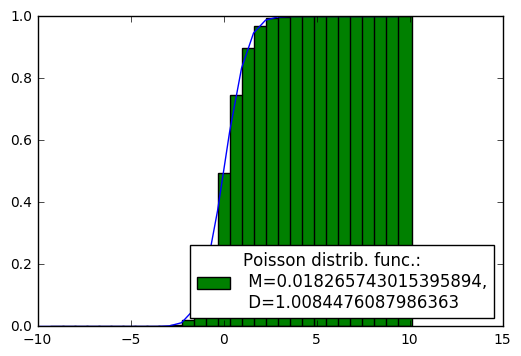

In [12]:
draw_empirical_distribution_func(res2, -10, 10, 30,
                                 func=normal_distribution_function, ax=plt.gca(), params={'M': 0, 'D': 1},
                                 label='Poisson distrib. func.:\n M={},\n D={}'.format(M(res2), D(res2)), loc=4)

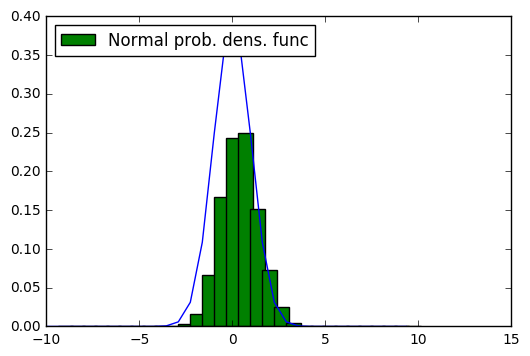

In [13]:
draw_empirical_histogram(res2, -10, 10, 30,
                         func=normal_probability_density_function, ax=plt.gca(), 
                         params={'M': 0, 'D': 1},
                         label='Normal prob. dens. func', loc=2)

In [14]:
psi3 = exponential_psi()
res3 = pd.Series([next(psi3) for _ in range(2000)])

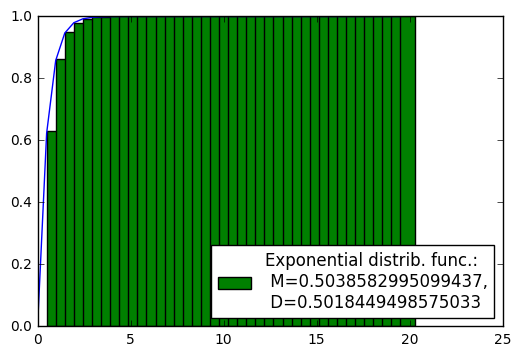

In [15]:
draw_empirical_distribution_func(res3, 0, 20, 40,
                                 func=exponential_distribution_function, ax=plt.gca(), params={'l': 2},
                                 label='Exponential distrib. func.:\n M={},\n D={}'.format(M(res3), D(res3)), loc=4)

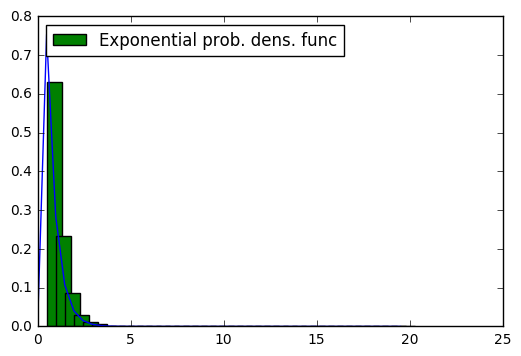

In [16]:
draw_empirical_histogram(res3, 0, 20, 40,
                         func=exponential_probability_density_function, ax=plt.gca(), params={'l': 2},
                         label='Exponential prob. dens. func', loc=2)

In [25]:
print("Критерий согласия Пирсона")
print("Poisson: ", pearson_test(res1, 0, 188, 40, 
                                func=poisson_distribution_function, params={'l': 1}))
print("Normal: ", pearson_test(res2, 0, 188, 40,
                               func=normal_distribution_function, params={'M': 0, 'D': 1}))
print("Exponential: ", pearson_test(res3, 0, 188, 40, 
                                    func=exponential_distribution_function, params={'l': 2}))

print("Exponential is Normal?: ", pearson_test(res3, 0, 188, 40, 
                                    func=normal_distribution_function, params={'M': 10, 'D': 0.5}))

Критерий согласия Пирсона
Poisson:  0.5121920935
Normal:  0.995615206079
Exponential:  0.469878197284
Exponential is Normal?:  0.425559401644


In [18]:
print("Критерий согласия Колмогорова")
print("Poisson: ", kolmogorov_test(res1, 0, 188, 40, 
                                   func=poisson_distribution_function, params={'l': 1}))
print("Normal: ", kolmogorov_test(res2, 0, 188, 40,
                                  func=normal_distribution_function, params={'M': 0, 'D': 1}))
print("Exponential: ", kolmogorov_test(res3, 0, 188, 40,
                                       func=exponential_distribution_function, params={'l': 2}))
print("Exponential is Normal?: ", kolmogorov_test(res3, 0, 188, 40,
                            func=normal_distribution_function, params={'M': 10, 'D': 0.5}))

Критерий согласия Колмогорова
Poisson:  1.0
Normal:  1.0
Exponential:  1.0
Exponential is Normal?:  1.0


In [112]:
n, ps = 20, [0.5, 0.5]
psi4 = polynomial_psi(n, ps)
res4 = pd.Series([next(psi4) for _ in range(2000)])

In [117]:
def binomial_probability_density_function(x, n, p):
    val = 1
    for i in range(1, int(x) + 1):
        val *= (n - i + 1) / i * p * (1 - p)
    return val * (1 - p) ** (n - 2 * x)

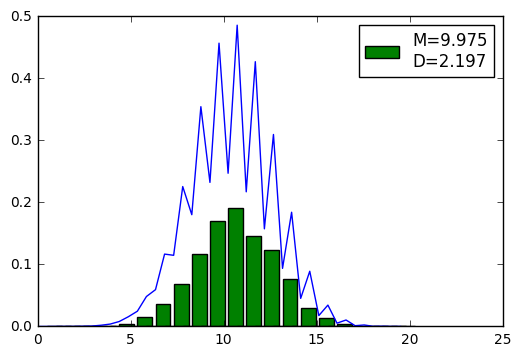

In [120]:
new_res4 = [x[0] for x in res4]
draw_empirical_histogram(new_res4, 0, 20, 40,
                         func=binomial_probability_density_function, ax=plt.gca(), params={'n': n, 'p': ps[0]},
                         label='M={:.4}\nD={:.4}'.format(M(new_res4), D(new_res4)), loc=1)

In [16]:
print("Критерий согласия Пирсона:")
print(pearson_test(new_res4, 
             xs=[i for i in range(0, n)],
             eps=0.037,
             func=binomial_probability_density_function,
             params={'n': n, 'p': ps[0]}))

Критерий согласия Пирсона:
True


/home/rustam/Desktop/Python/Imitation-and-static-modeling/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


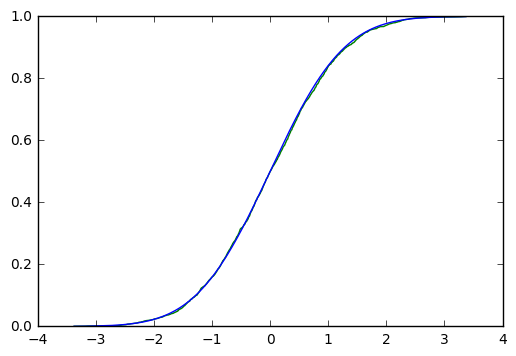

In [18]:
U, val1, val2 = 1, 0, 0

psi = normal_psi(12)
res = pd.Series([next(psi) for _ in range(2000)])
# if not pearson_test(res, 
#                     [i for i in np.arange(min(res), max(res), 0.2)], 
#                     eps=0.037,
#                     func=normal_distribution_function,
#                     params={'M': 0, 'D': 1}):
#     val1 += 1
# if not pearson_test(res, 
#                     [i for i in np.arange(min(res), max(res), 0.2)], 
#                     eps=0.037,
#                     func=exponential_distribution_function,
#                     params={'l': 0.5}):
#     val2 += 1
draw_empirical_distribution_func(res, 
                                 func=normal_distribution_function,
                                 params={'M': 0, 'D': 1},
                                 ax=plt.gca(),
                                 type='plot')
# print("For normal")
# print("Normal: ", val1 / U)
# print("Exponential: ", val2 / U)

/home/rustam/Desktop/Python/Imitation-and-static-modeling/venv/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


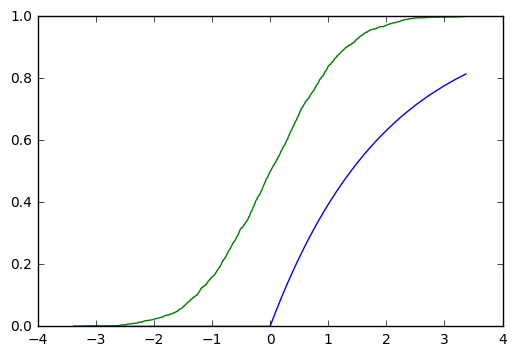

In [19]:
draw_empirical_distribution_func(res, 
                                 func=exponential_distribution_function,
                                 params={'l': 0.5},
                                 ax=plt.gca(),
                                 type='plot')